# ABIDE Subtype analysis
The goal of this notebook is to run a subtype analysis on the ABIDE dataset and to look at the subtype weights following Pierre Orban's analysis. Here are the central research questions:

1. What are subtypes of scores maps for different networks (7 network resolution on Cambridge) and how do they look like?
2. What are the individual subject weights for these subtypes (violin plots and Pierre's matrix)
3. For which networks and subtypes is diagnosis a significant predictor of weights?
4. What do weights for these subtypes and networks look like for patients and healthy controls?
5. For which networks and subtypes are dimensional scores like IQ significant predictors of weights?
5. What does the scatterplot of weights over IQ look like?

In [1]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import brainbox as bb
import nilearn as nil
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import gridspec
from scipy import cluster as scl
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as slin
from statsmodels.sandbox import stats as sts
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.sandbox.stats import multicomp as smi

In [2]:
%matplotlib inline

# Paths

In [3]:
# Paths
scale = 7
name = 'n308_sample'
mtp = 'stability_maps'
prior_path = '/data1/cambridge/template/template_cambridge_basc_multiscale_sym_scale{:03d}.nii.gz'.format(scale)
pheno_path = '/data1/abide/Pheno/unconstrained_2box_308_sample.csv'
netstack_path = '/data1/subtypes/serial_preps/netstack_demeaned_{}_scale_{:03d}.npy'.format(name, scale)
netraw_path = '/data1/subtypes/serial_preps/netstack_raw_{}_scale_{:03d}.npy'.format(name, scale)
corrmat_path = '/data1/subtypes/serial_preps/correlation_matrix_{}_scale_{:03d}.npy'.format(name, scale)
mask_path = '/data1/abide/Mask/mask_data_specific.nii.gz'
out_path = '/data1/subtypes/sc12'

In [4]:
# Get the mask
m_img = nib.load(mask_path)
mask_data = m_img.get_data()
mask = mask_data != 0

In [5]:
# Get the phenotype data
pheno = pd.read_csv(pheno_path)

In [6]:
# add coded variable for ratio of VIQ and PIQ
pheno['VerbRatio'] = pheno['VIQ'] / pheno['PIQ']

In [7]:
# Get the prior
p_img = nib.load(prior_path)
prior = p_img.get_data()

In [8]:
# Turn the priors into an image
prior = nib.load(prior_path)
prior_data = prior.get_data()
prior_temp = np.zeros((prior_data.shape + (scale,)))
for sc_id in range(scale):
    tmp = np.zeros_like(prior_data)
    tmp[prior_data==sc_id+1] = sc_id + 1
    prior_temp[..., sc_id] = tmp
prior_img = nib.Nifti1Image(prior_temp, affine=m_img.get_affine(), header=m_img.get_header())

# Define some functions and the niak colormap

In [9]:
# Define a new colormap
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 1.0, 1.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 1.0, 1.0),
                   (0.25, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.75, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'blue':  ((0.0, 1.0, 1.0),
                   (0.25, 1.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
hotcold = LinearSegmentedColormap('hotcold', cdict)

In [10]:
def show_subtype(net_id, sbt_id, gdavg_img, sbt_store,
                 sbt_store_demeaned, view_mode='x', threshold=0.1, 
                 view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):
    # Show the subtype
    fig = plt.figure(figsize=(24,50))
    gs = gridspec.GridSpec(12, 2, hspace=0.3)

    ax1 = fig.add_subplot(gs[0,0])
    nlp.plot_glass_brain(nil.image.index_img(gdavg_img, net_id), cmap=plt.cm.gnuplot, 
                             axes=ax1, colorbar=False, title='Scores average network {}'.format(net_id+1),
                            vmin=0, vmax=1)

    ax2 = fig.add_subplot(gs[0,1])
    # Turn the vectorized subtype into a volume
    sbt = sbt_store[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_glass_brain(sbt_img, cmap=plt.cm.gnuplot, 
                         axes=ax2, colorbar=True, title='Subtype {} network {}'.format(sbt_id+1, net_id+1),
                        vmin=0, vmax=1)
    
    ax3 = fig.add_subplot(gs[1,:])
    # Turn the vectorized demeaned subtype into a volume
    sbt_dm = sbt_store_demeaned[net_id,sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt_dm
    sbt_dm_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    nlp.plot_stat_map(sbt_dm_img, axes=ax3, display_mode=view_mode, threshold=threshold, 
                      cut_coords=view_range, black_bg=True)
    
    return fig

In [11]:
def report_weights(net_id, sbt_id, sub_asd, sub_tdc, weight_store):
    # Look at the weights for subtype 5
    sbt_weights = weight_store[net_id, sbt_id,:]
    # Get the weights for the asd and tdc cases
    asd_weights = sbt_weights[sub_asd]
    tdc_weights = sbt_weights[sub_tdc]
    n_asd = np.sum(sub_asd)
    n_tdc = np.sum(sub_tdc)
    # T-test
    [t,p] = st.ttest_ind(asd_weights, tdc_weights)

    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(121)
    # Indices
    ind_asd = np.ones(n_asd) + (np.random.random(n_asd)*2-1)*0.05
    ind_tdc = np.ones(n_tdc) + (np.random.random(n_tdc)*2-1)*0.05 + 1

    ax1.plot(ind_asd, asd_weights, 'k.')
    ax1.plot(ind_tdc, tdc_weights, 'k.')
    ax1.boxplot([asd_weights, tdc_weights])
    ax1.set_xticklabels(['ASD', 'TDC'], rotation=60)
    ax1.set_ylabel('weights')

    ax2 = fig.add_subplot(122)
    tmp = ax2.violinplot([asd_weights, tdc_weights])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(['ASD', 'TDC'], rotation=60)

    fig.suptitle('T-Test: T {:.2f}, p {:.4f}'.format(t,p))
    return fig

## Build the subtypes and compute the weights

In [12]:
# Load the serialized netstack
netstack = np.load(netstack_path)

corr_mat = np.load(corrmat_path)

In [13]:
# Make the grand average
gdavg = np.zeros(mask.shape + (scale,))

In [14]:
netraw = np.load(netraw_path)

In [15]:
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
inv_list = ['VIQ',  'ADOS_TOTAL', 'DX_GROUP']
subtypes = 5

print('\n{} subtypes'.format(subtypes))
scale = netstack.shape[0]
n_sub = netstack.shape[2]
n_vox = netstack.shape[1]

link_store = np.zeros((n_sub-1,4,scale))
part_store = np.zeros((scale, n_sub))
sbt_store = np.zeros((scale, subtypes, n_vox))
weight_store = np.zeros((scale, subtypes, n_sub))

# Iterate through the networks
for net_id in range(scale):
    # Compute linkage with Ward's criterion
    link_mat = scl.hierarchy.linkage(corr_mat[net_id, ...] , method='ward')
    link_store[..., net_id] = link_mat
    # Partition the linkage to get a given number of subtypes
    part_sub = scl.hierarchy.fcluster(link_mat, subtypes, criterion='maxclust')
    part_store[net_id, :] = part_sub

    sub_stack = np.zeros((n_vox, subtypes))
    for s_id in range(subtypes):
        sbt = np.mean(netstack[net_id, :, part_sub==s_id+1],0)
        sub_stack[:,s_id] = sbt
        sbt_store[net_id, s_id, :] = sbt

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])

    # Init store - Compute the weights
    for s_id in range(subtypes):
        type_map = sub_stack[:, s_id]
        weight_store[net_id, s_id, :] = np.array([np.corrcoef(type_map, netstack[net_id, :, x])[0,1] for x in range(n_sub)])


5 subtypes


In [16]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-3]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

In [17]:
print('{} has {}'.format(cov, np.sum(cov_index)))

ADOS_TOTAL has 136


In [18]:
cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

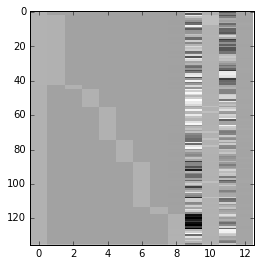

In [19]:
fig = plt.figure(figsize=(4,10))
ax = fig.add_subplot(111)
ax.imshow(glm_pheno, aspect=0.1, interpolation='None', cmap=plt.cm.Greys_r)

In [20]:
cov_weight = weight_store[..., cov_index.values]

In [21]:
res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)

# Look at the results

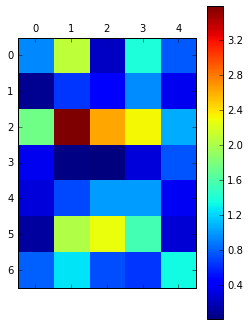

In [22]:
# Look at the uncorrected p-values for the GLM with diagnosis across networks
tmp = plt.matshow(-np.log10(pval_store))
tmp = plt.colorbar()

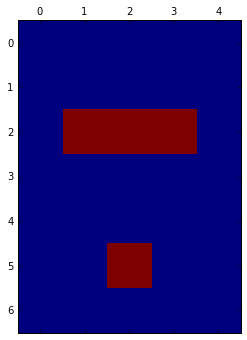

In [23]:
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

In [24]:
print(res_store[5][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5.878
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           5.41e-08
Time:                        02:25:09   Log-Likelihood:                 79.779
No. Observations:                 136   AIC:                            -133.6
Df Residuals:                     123   BIC:                            -95.69
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2029      0.119      1.704      

In [25]:
gdavg_img = nib.Nifti1Image(gdavg, affine=m_img.get_affine(), header=m_img.get_header())

In [26]:
def show_simple(net_id, sbt_id, gdavg_img, sbt_store, view_mode='x', threshold=0.1, 
                view_range=[-70,-50, -30, -10, 10, 30, 50, 70]):

    sbt = sbt_store[net_id, sbt_id,:]
    tmp = np.zeros_like(mask, dtype=np.float)
    tmp[mask] = sbt
    sbt_img = nib.Nifti1Image(tmp, affine=m_img.get_affine(), header=m_img.get_header())
    fig = plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    nlp.plot_stat_map(sbt_img, display_mode='x', threshold=threshold, 
                      cut_coords=view_range, black_bg=True,
                     axes=ax)
    return fig

In [27]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

## ADOS

### Network 2

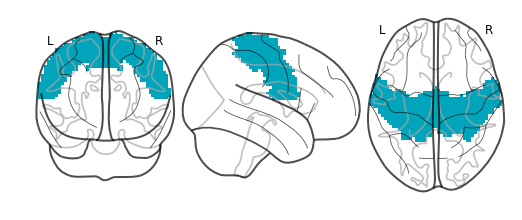

In [28]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 2), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [29]:
view_range=[-70,-50, -30, -10, 10, 30, 50, 70]

### pos

In [30]:
print(res_store[2][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     4.518
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           5.31e-06
Time:                        02:25:11   Log-Likelihood:                 70.174
No. Observations:                 136   AIC:                            -114.3
Df Residuals:                     123   BIC:                            -76.48
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0556      0.128     -0.436      

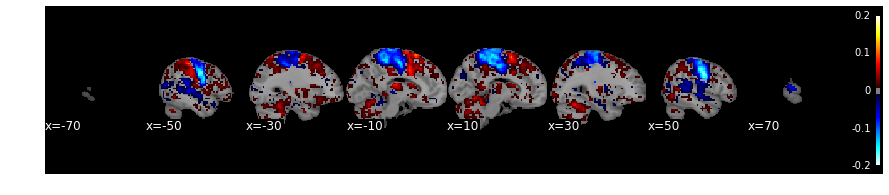

In [31]:
tmp = show_simple(2,1,gdavg_img, sbt_store, view_mode='x', view_range=view_range, threshold=0.01)

### neg

In [32]:
print(res_store[2][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     3.465
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           0.000205
Time:                        02:25:12   Log-Likelihood:                 71.997
No. Observations:                 136   AIC:                            -118.0
Df Residuals:                     123   BIC:                            -80.13
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0195      0.126     -0.154      

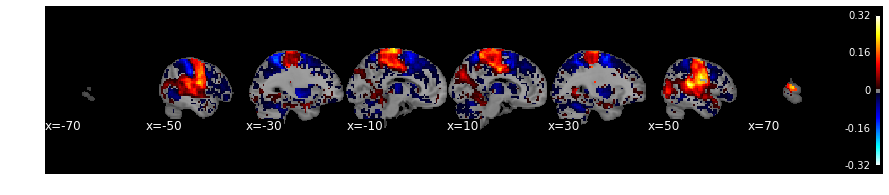

In [33]:
tmp = show_simple(2,2,gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [34]:
print(res_store[2][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     2.705
Date:                Sun, 08 Nov 2015   Prob (F-statistic):            0.00285
Time:                        02:25:13   Log-Likelihood:                 52.290
No. Observations:                 136   AIC:                            -78.58
Df Residuals:                     123   BIC:                            -40.71
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0265      0.146      0.182      

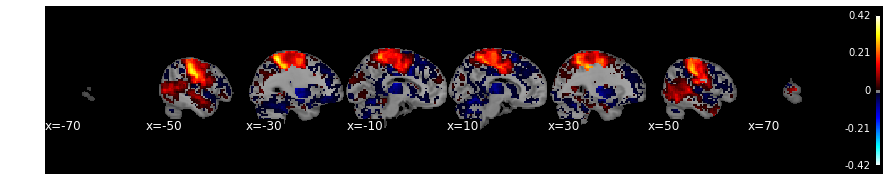

In [35]:
tmp = show_simple(2,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### Network 5

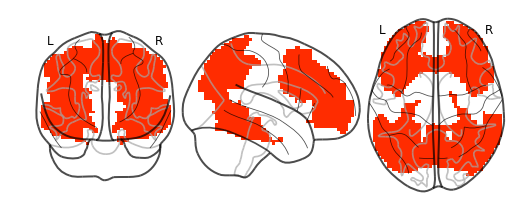

In [36]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 5), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg

In [37]:
print(res_store[5][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     5.878
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           5.41e-08
Time:                        02:25:15   Log-Likelihood:                 79.779
No. Observations:                 136   AIC:                            -133.6
Df Residuals:                     123   BIC:                            -95.69
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2029      0.119      1.704      

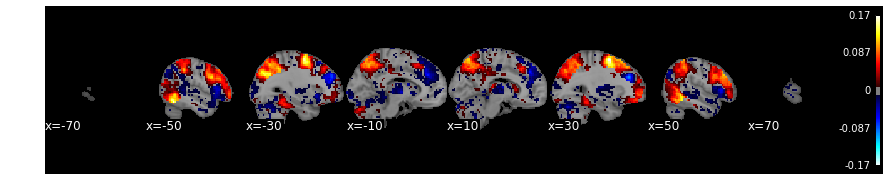

In [38]:
tmp = show_simple(5,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# Quick look at Diagnosis
I want to compare the patterns

DX_GROUP has 308


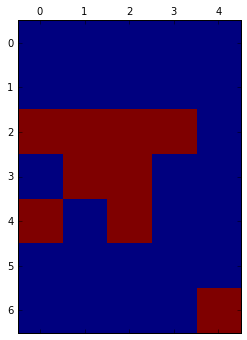

In [39]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[-1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 2

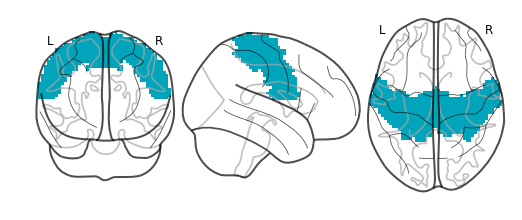

In [40]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 2), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg (pos for disease)

In [41]:
print(res_store[2][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     4.911
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           8.47e-08
Time:                        02:25:17   Log-Likelihood:                 83.802
No. Observations:                 308   AIC:                            -139.6
Df Residuals:                     294   BIC:                            -87.38
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2306      0.074     -3.104      

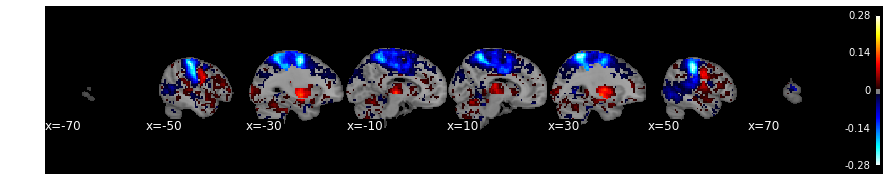

In [42]:
tmp = show_simple(2,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [43]:
print(res_store[2][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     8.858
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           2.68e-15
Time:                        02:25:18   Log-Likelihood:                 142.33
No. Observations:                 308   AIC:                            -256.7
Df Residuals:                     294   BIC:                            -204.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.2614      0.061     -4.255      

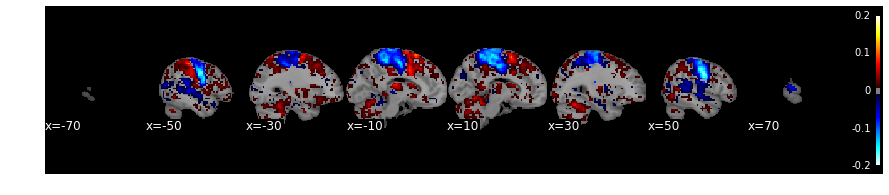

In [44]:
tmp = show_simple(2,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos (neg for disease)

In [45]:
print(res_store[2][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     5.865
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.21e-09
Time:                        02:25:19   Log-Likelihood:                 135.48
No. Observations:                 308   AIC:                            -243.0
Df Residuals:                     294   BIC:                            -190.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.0949      0.063      1.511      

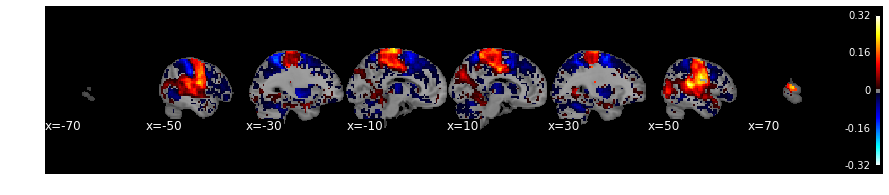

In [46]:
tmp = show_simple(2,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [47]:
print(res_store[2][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     6.675
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           3.35e-11
Time:                        02:25:19   Log-Likelihood:                 94.841
No. Observations:                 308   AIC:                            -161.7
Df Residuals:                     294   BIC:                            -109.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2436      0.072      3.400      

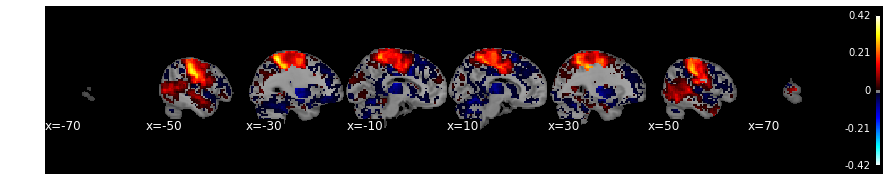

In [48]:
tmp = show_simple(2,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 3

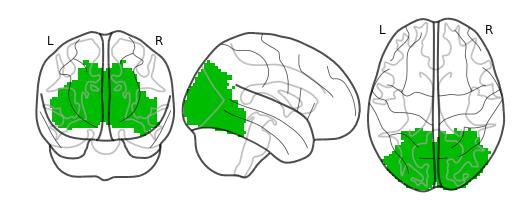

In [49]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 3), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### neg (pos for disease)

In [50]:
print(res_store[3][1].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     8.947
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.83e-15
Time:                        02:25:21   Log-Likelihood:                 159.27
No. Observations:                 308   AIC:                            -290.5
Df Residuals:                     294   BIC:                            -238.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1289      0.058     -2.216      

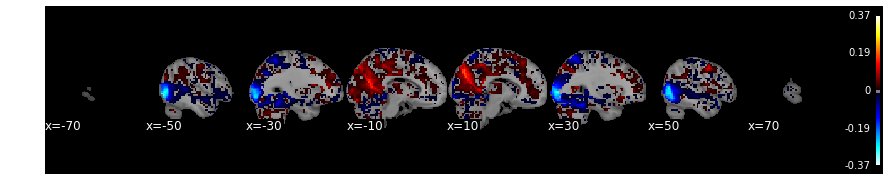

In [51]:
tmp = show_simple(3,1, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

### pos (neg for disease)

In [52]:
print(res_store[3][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     10.19
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.01e-17
Time:                        02:25:22   Log-Likelihood:                 147.08
No. Observations:                 308   AIC:                            -266.2
Df Residuals:                     294   BIC:                            -213.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.1623      0.060      2.683      

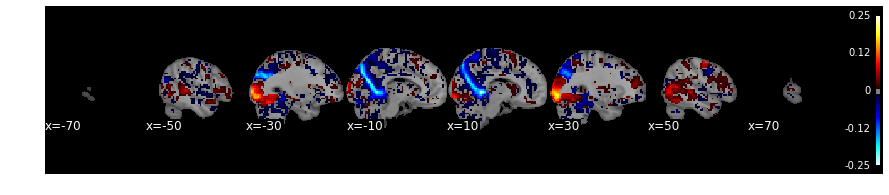

In [53]:
tmp = show_simple(3,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 4

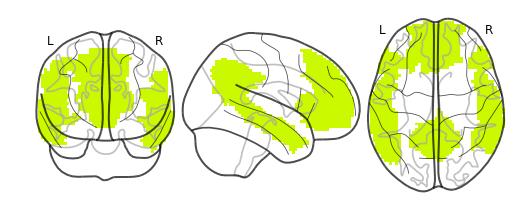

In [54]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 4), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

### pos (neg for disease)

In [55]:
print(res_store[4][0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     12.34
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.81e-21
Time:                        02:25:24   Log-Likelihood:                 181.47
No. Observations:                 308   AIC:                            -334.9
Df Residuals:                     294   BIC:                            -282.7
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2438      0.054      4.507      

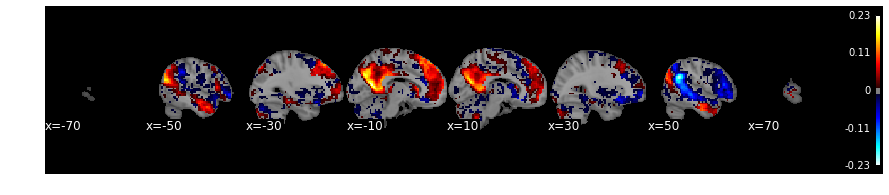

In [56]:
tmp = show_simple(4,0, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

###  neg (pos for disease)

In [57]:
print(res_store[4][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     11.73
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.97e-20
Time:                        02:25:25   Log-Likelihood:                 140.06
No. Observations:                 308   AIC:                            -252.1
Df Residuals:                     294   BIC:                            -199.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.3070      0.062     -4.961      

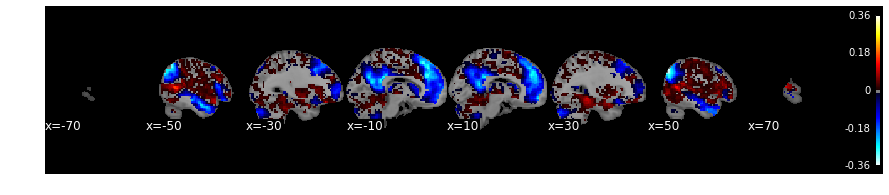

In [58]:
tmp = show_simple(4,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

# Look at VIQ

VIQ has 276


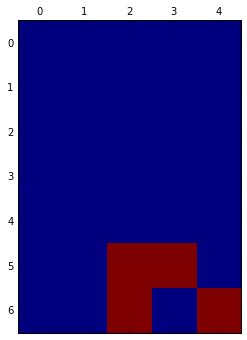

In [59]:
# Reduce the phenotype data to those subjects 
# that actually have the covariate of interest
cov_list = ['FIQ', 'VIQ', 'PIQ', 'ADI_R_SOCIAL_TOTAL_A',
            'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 
            'VINELAND_ABC_STANDARD', 'ADOS_TOTAL', 'SRS_RAW_TOTAL', 'DX_GROUP']
cov = cov_list[1]
cov_index = pd.notnull(pheno.replace(-9999, np.nan)[cov])

print('{} has {}'.format(cov, np.sum(cov_index)))

cov_pheno = pheno[cov_index]
# Generate the model matrix
factors = [cov, 'SEX', 'AGE_AT_SCAN', 'FD_scrubbed']
# Make dummy variables for the site factor
site_factor = pd.get_dummies(cov_pheno['SITE_ID'])
# Turn the first site into the intercept
site_factor = site_factor.rename(columns={site_factor.keys()[0]: 'INTERCEPT'})
site_factor['INTERCEPT'] = 1
# Get the other variables
other_factors = cov_pheno.ix[:,factors]
# Turn diagnosis into [0,1] vector
#other_factors['DX_GROUP'] = other_factors['DX_GROUP'].values - 1
# Demean age
other_factors['AGE_AT_SCAN'] = other_factors['AGE_AT_SCAN']-np.mean(other_factors['AGE_AT_SCAN'].values)
# Demean the covariate
other_factors[cov] = other_factors[cov]-np.mean(other_factors[cov].values)
# Put them back together
glm_pheno = pd.concat([site_factor, other_factors], axis=1)

cov_weight = weight_store[..., cov_index.values]

res_store = list()
pval_store = np.zeros((scale, subtypes))
for net_id in range(scale):
    res_list = list()
    # Loop through the subtypes
    for s_id in range(subtypes):
        model = sm.OLS(cov_weight[net_id, s_id, :], glm_pheno)
        results = model.fit()
        # Save the p-values
        pval_store[net_id, s_id] = results.pvalues[cov]
        res_list.append(results)
    res_store.append(res_list)
    
# Now look at the mask of p-values passing FDR Correction
pval_vec = np.reshape(pval_store, np.prod(pval_store.shape))
pcorr_vec = sts.multicomp.fdrcorrection0(pval_vec, 0.05)
pcorr_store = np.reshape(pcorr_vec[0], pval_store.shape)
tmp = plt.matshow(pcorr_store)

## Network 5

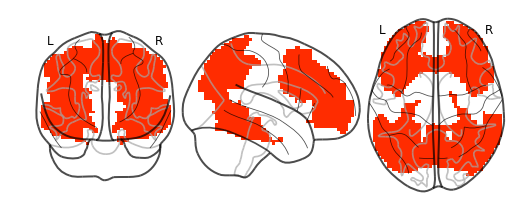

In [60]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 5), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [61]:
print(res_store[5][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     9.680
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           9.34e-14
Time:                        02:25:27   Log-Likelihood:                 153.11
No. Observations:                 276   AIC:                            -284.2
Df Residuals:                     265   BIC:                            -244.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT       0.2895      0.058      5.031      

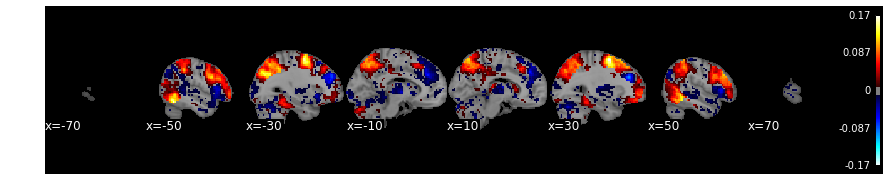

In [62]:
tmp = show_simple(5,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [63]:
print(res_store[5][3].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.186
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.71e-08
Time:                        02:25:29   Log-Likelihood:                 170.73
No. Observations:                 276   AIC:                            -319.5
Df Residuals:                     265   BIC:                            -279.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1295      0.054     -2.399      

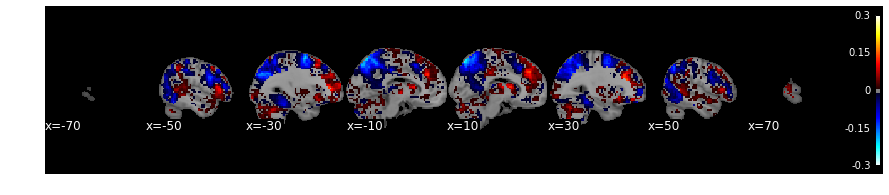

In [64]:
tmp = show_simple(5,3, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

## Network 6

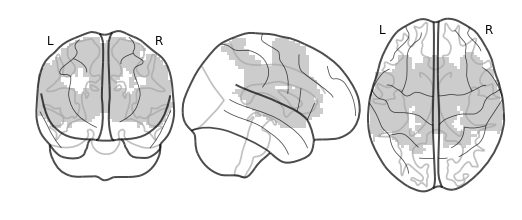

In [65]:
nlp.plot_glass_brain(nil.image.index_img(prior_img, 6), cmap=plt.cm.spectral, 
                     colorbar=False, vmin=1, vmax=scale)

In [66]:
print(res_store[6][2].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.190
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.69e-08
Time:                        02:25:31   Log-Likelihood:                 180.67
No. Observations:                 276   AIC:                            -339.3
Df Residuals:                     265   BIC:                            -299.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.0181      0.052     -0.348      

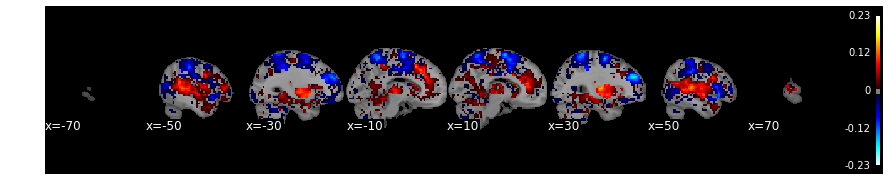

In [67]:
tmp = show_simple(6,2, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)

In [68]:
print(res_store[6][4].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     8.184
Date:                Sun, 08 Nov 2015   Prob (F-statistic):           1.54e-11
Time:                        02:25:31   Log-Likelihood:                 150.72
No. Observations:                 276   AIC:                            -279.4
Df Residuals:                     265   BIC:                            -239.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
INTERCEPT      -0.1331      0.058     -2.293      

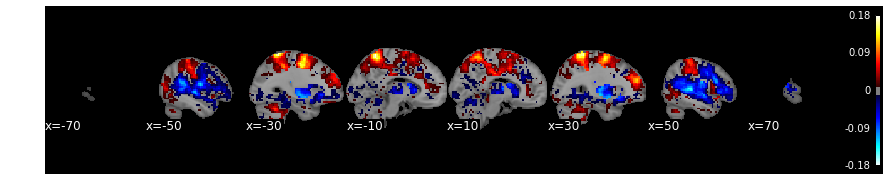

In [69]:
tmp = show_simple(6,4, gdavg_img, sbt_store, view_mode='x',  view_range=view_range, threshold=0.01)